In [1]:
try:
    %matplotlib widget
except:
    print("Matplotlib widget not available")

In [2]:
import os
import numpy as np
import pycolmap
import matplotlib.pyplot as plt
from matplotlib.image import imread

from megadepth.utils.read_write_dense import read_array

In [3]:
reconstruction = pycolmap.Reconstruction("../data/03_dense_model/south-building/0/sparse")

dense_dir = os.path.join("..", "data", "03_dense_model", "south-building", "0")

images = reconstruction.images
cameras = reconstruction.cameras
point3D = reconstruction.points3D

In [36]:
id_1 = 26
id_2 = 28

In [5]:
generate_graphs = True

In [6]:
downsample = 10

In [7]:
image1 = images[id_1]
image2 = images[id_2]

camera1 = cameras[image1.camera_id]
camera2 = cameras[image2.camera_id]

In [8]:
depth1 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{image1.name}.geometric.bin"))
colors1 = imread(os.path.join(dense_dir, "images", image1.name))
depth2 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{image2.name}.geometric.bin"))
colors2 = imread(os.path.join(dense_dir, "images", image2.name))

In [10]:
def pixel_grid(camera : pycolmap.Camera, downsample : int, reverse_x : bool = False, reverse_y : bool = False) -> np.ndarray:
    if reverse_x:
        xl = np.linspace(camera.width-1, 0, camera.width)[::downsample]
    else:
        xl = np.linspace(0, camera.width-1, camera.width)[::downsample]
        
    if reverse_y:
        yl = np.linspace(camera.height-1, 0, camera.height)[::downsample]
    else:
        yl = np.linspace(0, camera.height-1, camera.height)[::downsample]
    
    xv, yv = np.meshgrid(xl, yl)
    return np.vstack((np.ravel(xv),np.ravel(yv))).T

In [11]:
def filter_mask(data : np.ndarray, w : int, h : int) -> np.ndarray:
    # Get the x and y coordinates
    x = data[:, 0]
    y = data[:, 1]
    mask = (x >= 0) & (x <= w) & (y >= 0) & (y <= h)
    return mask

In [59]:
def forward_project(points_3d : np.ndarray, image : pycolmap.Image, camera : pycolmap.Camera, return_mask : bool = True, return_depth : bool = False) -> tuple:
    """
    Project list of 3d points onto the given image

    Args:
        points_3d (np.ndarray): list of 3d points; shape (n, 3)
        image (pycolmap.Image): image onto which the points are projected
        camera (pycolmap.Camera): camera associated with the image
        return_mask (bool, optional): whether to return a mask for the 2d points inside the camera bounds. Defaults to True.
        return_depth (bool, optional): whether to return the depth values for the projected 2d points. Defaults to False.

    Returns:
        tuple: _description_
    """
    uv = np.array(camera.world_to_image(image.project(points_3d)), dtype = int)
    
    return_array = [uv]
    
    if return_mask:
        mask = filter_mask(uv, camera.width, camera.height)
        return_array.append(mask)
    if return_depth:
        depth = np.array(image.transform_to_image(points_3d))[:, 2]
        return_array.append(depth)
    
    return uv if not return_mask and not return_depth else tuple(return_array)

In [60]:
def backward_project(points2d : np.ndarray, image : pycolmap.Image, camera : pycolmap.Camera, depth : np.ndarray) -> tuple:
    """
    Project list of 2d points into the 3d world space given a depth map

    Args:
        points2d (np.ndarray): list of 2d points; shape (n, 2)
        image (pycolmap.Image): image from which the points are taken
        camera (pycolmap.Camera): camera associated with the image
        depth (np.ndarray): associated depth map
        colors (np.ndarray, optional): a list of colors associated with each 2d point. Defaults to None.

    Returns:
        tuple: _description_
    """
    if len(depth.shape) > 1:
        depth_d = depth.ravel()
    else:
        depth_d = depth
    
    p_world = np.array(camera.image_to_world(points2d))
    p_world = np.stack([p_world[:, 0], p_world[:, 1], np.ones_like(p_world[:, 0])]) * depth_d
    p_world = np.array(image.transform_to_world(p_world.T))
    
    return p_world


# Backward Projection Example

In [63]:
depth1_d = depth1[::downsample, ::downsample]
depth2_d = depth2[::downsample, ::downsample]

world_p1 = backward_project(pixel_grid(camera1, downsample), image1, camera1, depth1_d)
world_p2 = backward_project(pixel_grid(camera1, downsample), image2, camera2, depth2_d)

colors1_d = colors1[::downsample, ::downsample].reshape(-1, 3)
colors2_d = colors2[::downsample, ::downsample].reshape(-1, 3)

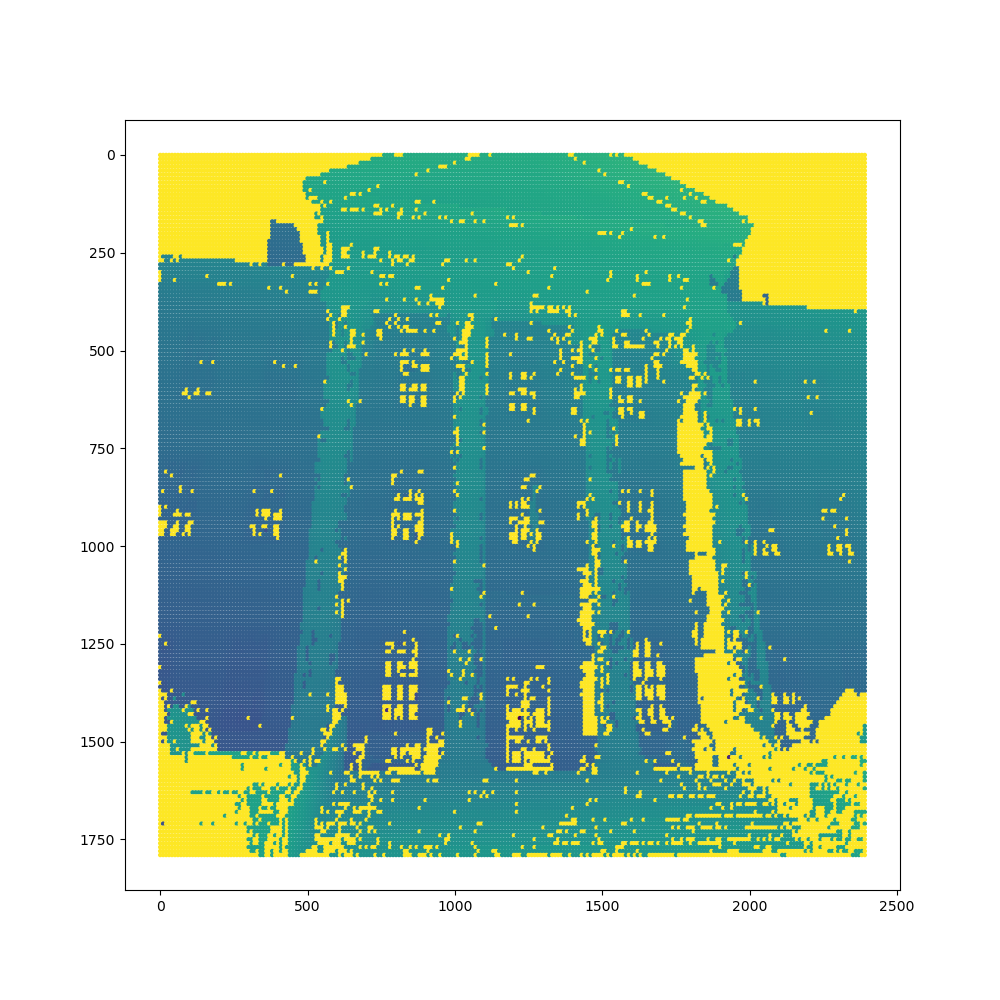

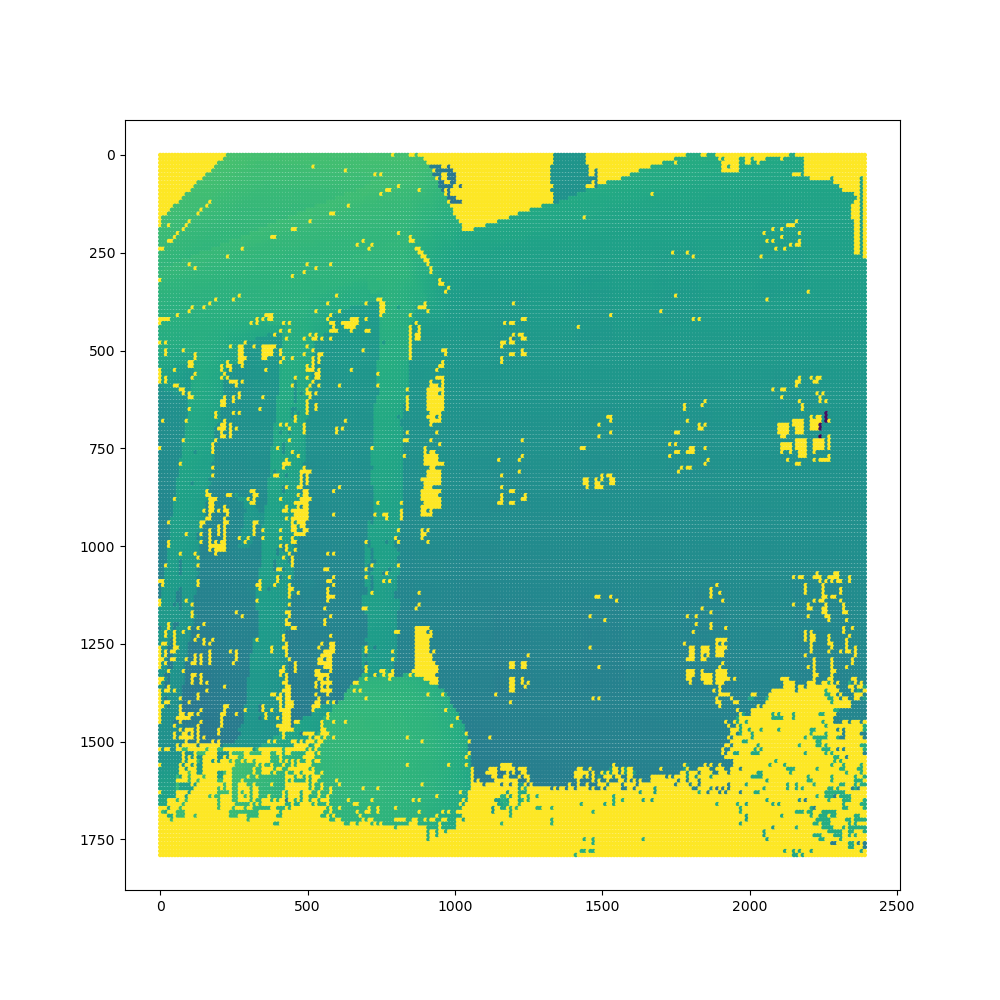

In [64]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    xy1 = pixel_grid(camera1, downsample)
    plt.gca().invert_yaxis()
    ax.scatter(xy1[:, 0], xy1[:, 1], c = world_p1[:, 2], s = 5)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    xy2 = pixel_grid(camera2, downsample)
    plt.gca().invert_yaxis()
    ax.scatter(xy2[:, 0], xy2[:, 1], c = world_p2[:, 2], s = 5)
    plt.show()

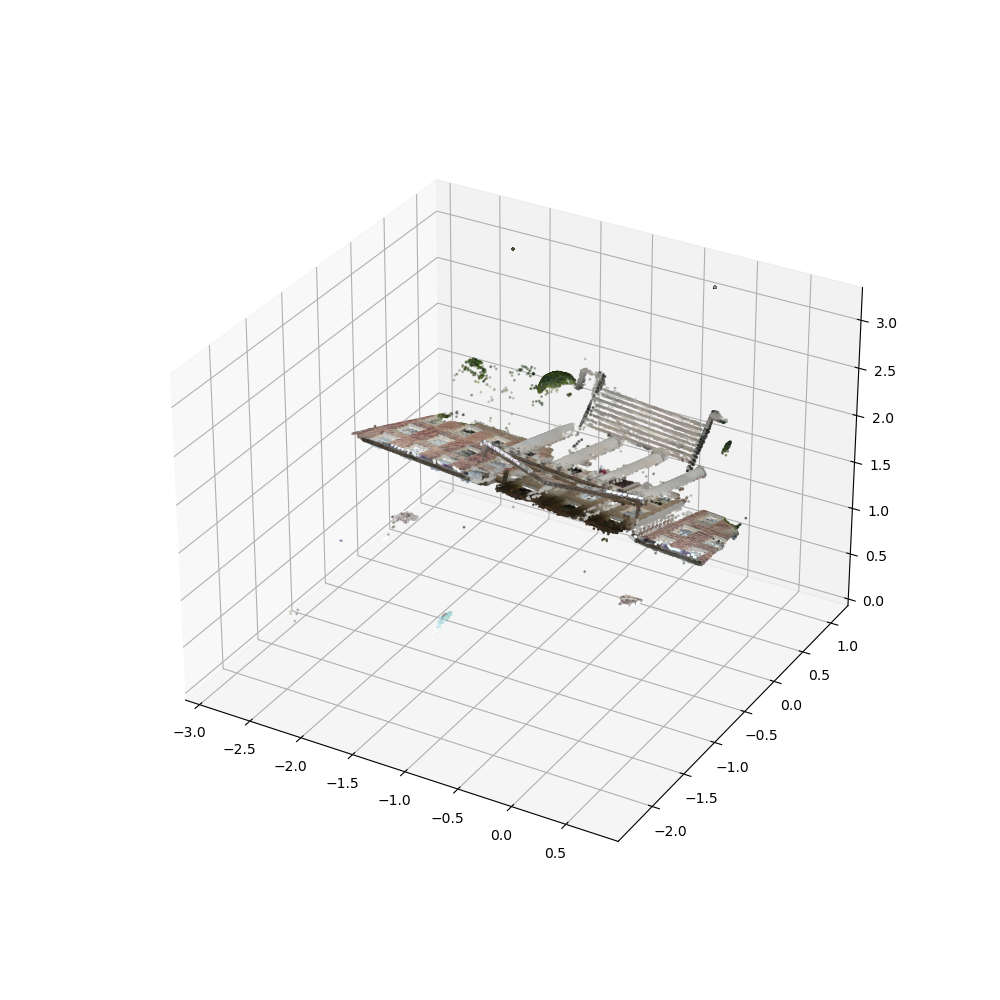

In [65]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

    ax.scatter(world_p1[:, 0], world_p1[:, 1], world_p1[:, 2], s=1, c = colors1_d / 255)
    ax.scatter(world_p2[:, 0], world_p2[:, 1], world_p2[:, 2], s=1, c = colors2_d / 255)

    plt.show()

# Forward Projection Example

In [66]:
uv1, mask1, re_depth1 = forward_project(world_p1, image2, camera2, return_depth = True)
uv2, mask2, re_depth2 = forward_project(world_p2, image1, camera1, return_depth = True)

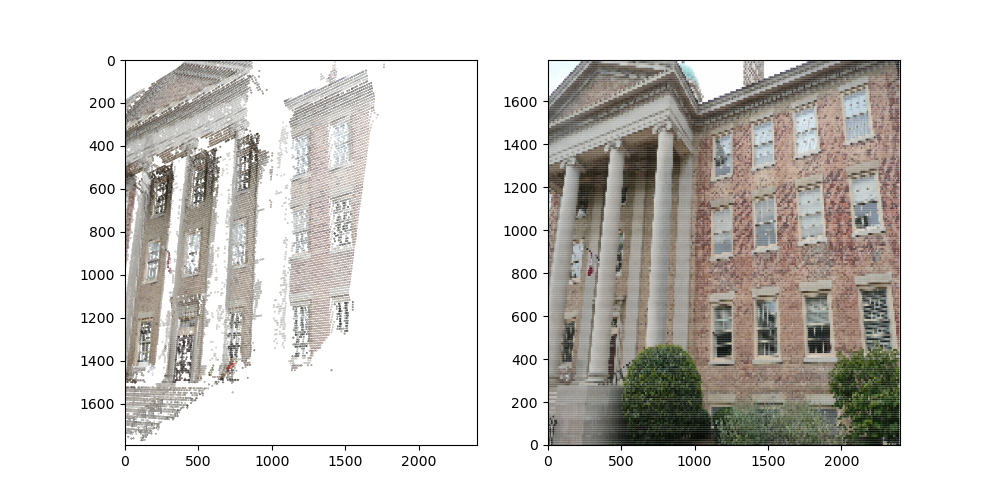

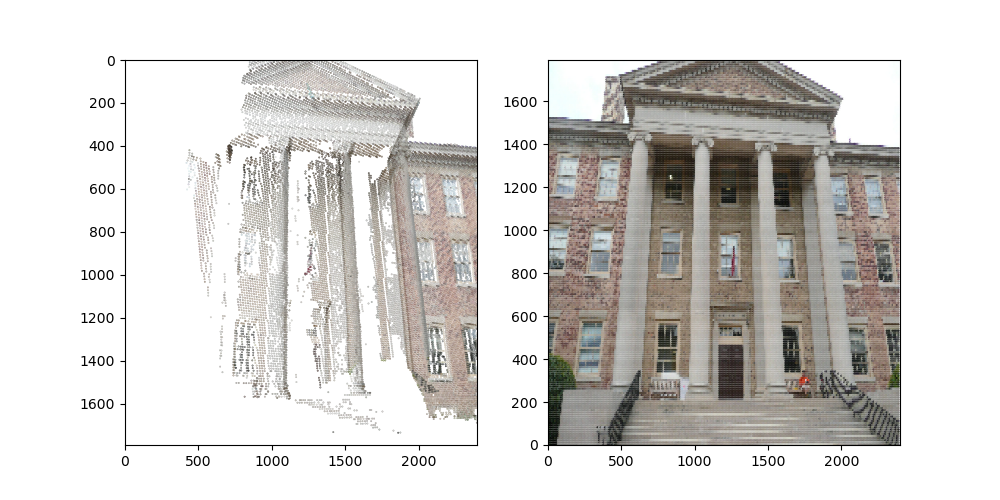

In [67]:
if generate_graphs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlim([0, camera2.width])
    ax1.set_ylim([0, camera2.height])
    ax1.invert_yaxis()
    ax1.scatter(uv1[mask1, 0], uv1[mask1, 1], c = colors1_d[mask1, :] / 255, s = 0.1)
    xy2 = pixel_grid(camera2, downsample, reverse_y = True)
    ax2.set_xlim([0, camera2.width])
    ax2.set_ylim([0, camera2.height])
    ax2.scatter(xy2[:, 0], xy2[:, 1], c = colors2_d / 255, s = 0.5)
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlim([0, camera1.width])
    ax1.set_ylim([0, camera1.height])
    ax1.invert_yaxis()
    ax1.scatter(uv2[mask2, 0], uv2[mask2, 1], c = colors2_d[mask2, :] / 255, s = 0.1)
    xy1 = pixel_grid(camera1, downsample, reverse_y = True)
    ax2.set_xlim([0, camera1.width])
    ax2.set_ylim([0, camera1.height])
    ax2.scatter(xy1[:, 0], xy1[:, 1], c = colors1_d / 255, s = 0.5)
    plt.show()

## Depth Error

In [68]:
depth_errors1 = np.abs(depth2[::downsample, ::downsample].ravel() - re_depth1)
depth_errors2 = np.abs(depth1[::downsample, ::downsample].ravel() - re_depth2)

In [69]:
inliner1 = depth_errors1<0.5
score1 = np.count_nonzero(inliner1)*downsample*downsample/camera1.width/camera1.height

inliner2 = depth_errors2<0.5
score2 = np.count_nonzero(inliner2)*downsample*downsample/camera2.width/camera2.height

In [70]:
print(np.count_nonzero(depth_errors1<0.05))
print(np.count_nonzero(depth_errors1>0.05))

2133
41067


In [71]:
print(score1)
print(score2)

0.6090118981223275
0.7241355270496375


<ipython-input-72-9e7b7afcee51>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))


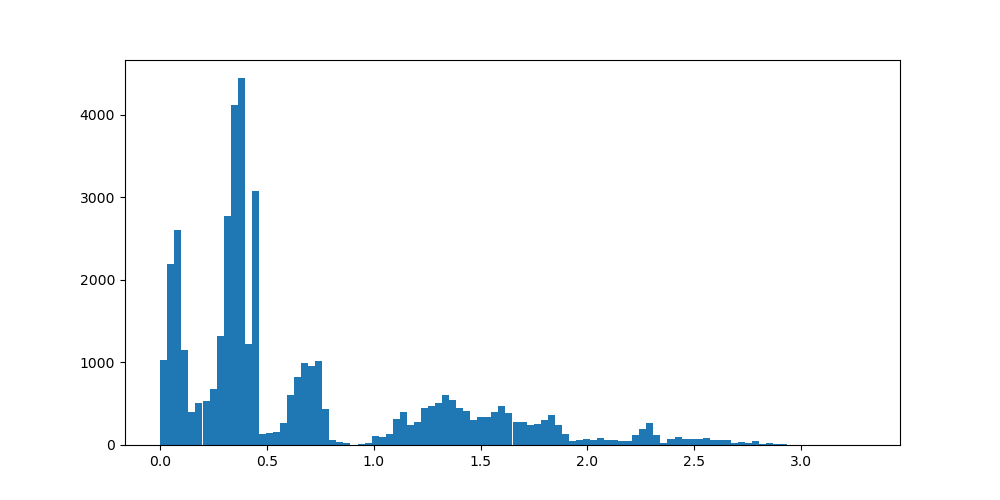

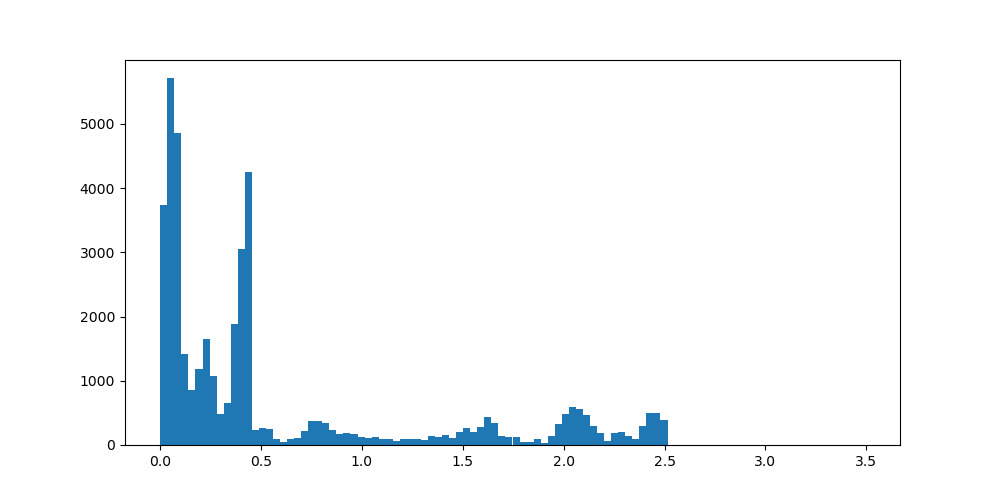

In [72]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(depth_errors1,bins=100)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(depth_errors2,bins=100)
    plt.show()

# Reprojection Error

In [73]:
xy = pixel_grid(camera1, downsample)

In [77]:
depth1_d = depth1[::downsample, ::downsample]
colors_d = colors1[::downsample, ::downsample].reshape(-1, 3)

In [78]:
world_p1 = backward_project(xy, image1, camera1, depth1_d)

In [79]:
p1_to_im2, mask, re_depth = forward_project(world_p1, image2, camera2, return_depth = True)

In [80]:
re_world_p1 = backward_project(p1_to_im2, image2, camera2, re_depth)

In [81]:
reproj_p1, mask2 = forward_project(re_world_p1, image1, camera1, return_depth = False)

In [82]:
xy.shape

(43200, 2)

In [83]:
reproj_p1.shape

(43200, 2)

In [84]:
# l1 (Manhattan distance) between original and reprojected
reproj_diff = np.abs(xy - reproj_p1).sum(axis = 1)
# l2 (Euler distance) between original and reprojected
#reproj_diff = np.sqrt(np.power(xy - reproj_p1, 2).sum(axis = 1))

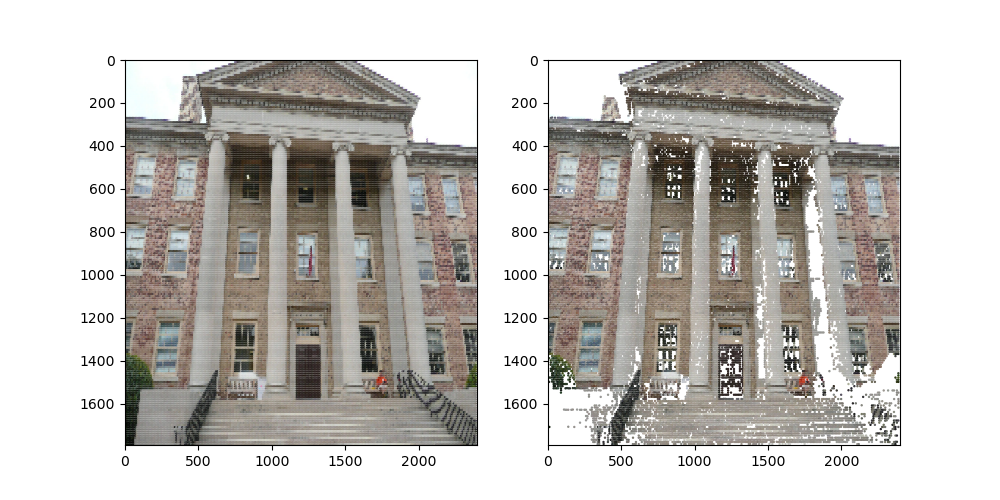

In [85]:
if generate_graphs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlim([0, camera1.width])
    ax1.set_ylim([0, camera1.height])
    ax1.invert_yaxis()
    ax1.scatter(xy[:, 0], xy[:, 1], c = colors_d / 255, s = 0.5)
    
    ax2.set_xlim([0, camera2.width])
    ax2.set_ylim([0, camera2.height])
    ax2.invert_yaxis()
    ax2.scatter(reproj_p1[:, 0], reproj_p1[:, 1], c = colors_d / 255, s = 0.5)
    plt.show()

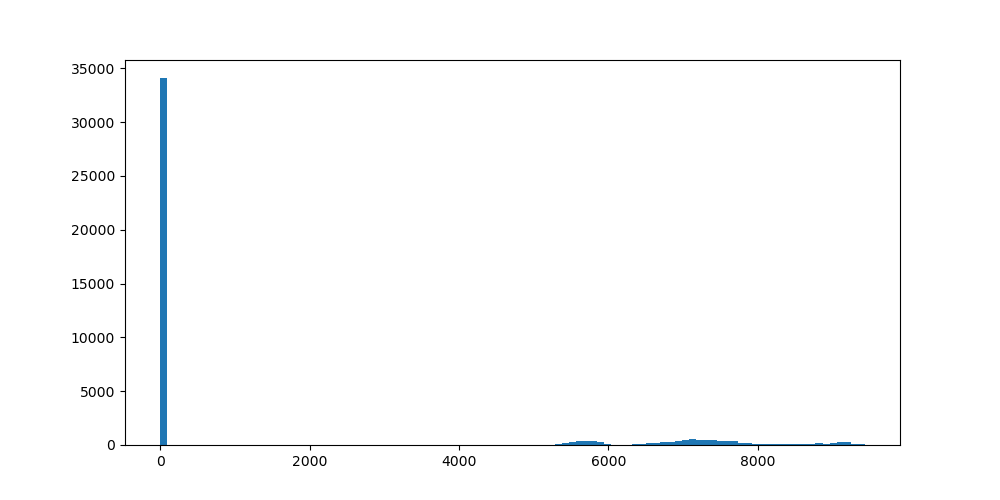

In [86]:
if generate_graphs:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(reproj_diff,bins=100)
    plt.show()

In [121]:
inliner = reproj_diff < 2000
score = np.count_nonzero(inliner) / xy.shape[0]

In [122]:
np.count_nonzero(inliner)

34069

In [123]:
print(score)

0.7886342592592592
